<a href="https://colab.research.google.com/github/ChaosShadoww/market-anomaly-detection/blob/main/Anomaly%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: upload data from this sheet https://docs.google.com/spreadsheets/d/1OQwkd5mkeWWR9qyDuI2aXxa-BlTu4F6EodNk9Lr_zsQ/edit?gid=1235822571#gid=1235822571

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1OQwkd5mkeWWR9qyDuI2aXxa-BlTu4F6EodNk9Lr_zsQ/edit?gid=1235822571#gid=1235822571'
# Extract the spreadsheet ID from the URL
spreadsheet_id = spreadsheet_url.split('/d/')[1].split('/')[0]

workbook = gc.open_by_key(spreadsheet_id)

# Choose the worksheet by index (0-based) or title.
# Replace 'Sheet1' with the actual sheet name if different.
worksheet = workbook.worksheet('EWS') # Or workbook.get_worksheet(0)

# Get all values from the sheet
data = worksheet.get_all_values()


# Example: convert to pandas DataFrame
import pandas as pd
df = pd.DataFrame(data[1:], columns=data[0]) # Assuming the first row is a header

In [ ]:
# prompt: make a column for month from a date for MM/DD/YYYY format. make a column for financial quarter

# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Data'], format='%m/%d/%Y')

# Extract the year
df['Year'] = df['Date'].dt.year

# Extract the month
df['Month'] = df['Date'].dt.month

# Extract the quarter
df['Quarter'] = df['Date'].dt.quarter

# Extract the week within the quarter
df['Week'] = df['Date'].dt.isocalendar().week

# Extract the day within the quarter
df['Day'] = df['Date'].dt.day

df['Week_in_Quarter'] = (df['Week'] % 13) + 1
df['Day_in_Quarter'] = (df['Day'] % 92) + 1


In [ ]:
features = df.drop(['Y', 'Data', 'Date'], axis=1)


In [ ]:
from sklearn.ensemble import IsolationForest
forest = IsolationForest(random_state=0)
forest.fit(features)

IsolationForest(random_state=0)

In [ ]:
scores = forest.score_samples(features)
scores

array([-0.5788021 , -0.56831984, -0.57244155, ..., -0.58051993,
       -0.5745983 , -0.57420622])

In [ ]:
df['Anomaly_Score'] = scores
df_sorted = df.sort_values(by=['Anomaly_Score']) # Sort by Anomaly_Score column
df_sorted

,Y,Data,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,...,Year,Month,Quarter,Week,Day,Week in Quarter,Week_in_Quarter,Day_in_Quarter,score,Anomaly_Score
1095,0,1/5/2021,1950.23,0.241,1418,171.7048,89.436,102.65,1.3633,49.93,...,2021,1,1,1,5,1,2,6,-0.589770,-0.595526
1099,0,2/2/2021,1835.24,0.362,1380,178.0224,91.197,105.1,1.3647,54.76,...,2021,2,1,5,2,5,6,3,-0.590412,-0.594408
1094,0,12/29/2020,1879.17,0.245,1366,165.3742,89.994,103.53,1.349,48,...,2020,12,4,53,29,197,2,30,-0.578881,-0.589415
1054,1,3/24/2020,1627.860,0.317,603.000,128.155,102.039,111.470,1.172,24.010,...,2020,3,1,13,24,13,1,25,-0.561709,-0.586387
1055,1,3/31/2020,1597.890,0.366,626.000,121.787,99.048,107.780,1.240,20.480,...,2020,3,1,14,31,14,2,32,-0.567558,-0.584365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,0,2/17/2015,1206.770,-0.196,516.000,228.795,94.061,119.100,1.536,53.530,...,2015,2,1,8,17,8,9,18,-0.468682,-0.442493
709,0,8/13/2013,1321.660,0.069,1007.000,288.076,81.768,98.120,1.546,106.830,...,2013,8,3,33,13,129,8,14,-0.447116,-0.442014
917,0,8/8/2017,1256.260,-0.202,1038.000,181.089,93.647,110.490,1.298,49.170,...,2017,8,3,32,8,128,7,9,-0.450958,-0.440919
914,0,7/18/2017,1242.180,-0.172,932.000,176.878,94.604,112.050,1.305,46.400,...,2017,7,3,29,18,125,4,19,-0.450320,-0.440770


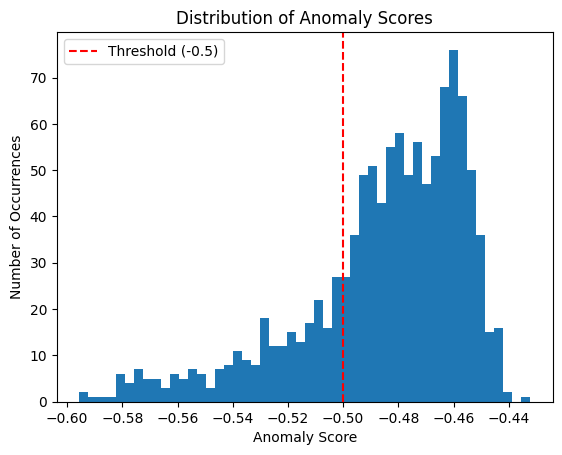

In [ ]:

import matplotlib.pyplot as plt
scoreThreshold = -0.5

plt.hist(scores, bins=50)  # Adjust the number of bins as needed
plt.xlabel("Anomaly Score")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Anomaly Scores")
plt.axvline(x=scoreThreshold, color='red', linestyle='--', label=f'Threshold ({scoreThreshold})')

plt.legend()
plt.show()

In [ ]:
scores_df = pd.DataFrame(scores, columns=['score'])


In [ ]:
# prompt: give me filtered scores that are less than -0.5

anomaly_scores = scores_df[scores_df['score'] < -0.5]
nonanomaly_scores = scores_df[scores_df['score'] > -0.5]
print(anomaly_scores)
print(nonanomaly_scores)

         score
0    -0.580773
1    -0.568899
2    -0.573051
3    -0.564334
4    -0.547707
...        ...
1106 -0.577530
1107 -0.579046
1108 -0.582562
1109 -0.568588
1110 -0.575643

[310 rows x 1 columns]
         score
66   -0.495527
67   -0.498527
69   -0.484231
71   -0.487925
80   -0.493857
...        ...
1012 -0.481848
1013 -0.492879
1014 -0.494328
1017 -0.499109
1018 -0.496337

[801 rows x 1 columns]


In [ ]:
scores_df.describe()

,score
count,1111.000000
mean,-0.488875
std,0.030838
min,-0.590491
25%,-0.503088
50%,-0.481628
75%,-0.466285
max,-0.436493


SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-87-05f2bbda6fbc>, line 2)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc


In [ ]:
import shap
import numpy as np
explainer = shap.TreeExplainer(forest)
random_indices = np.random.choice(len(features), 5000)
shap_values_random = explainer.shap_values(features.iloc[random_indices, :])
random_features = features.iloc[random_indices, :]

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_random[0, :], random_features.iloc[0, :])


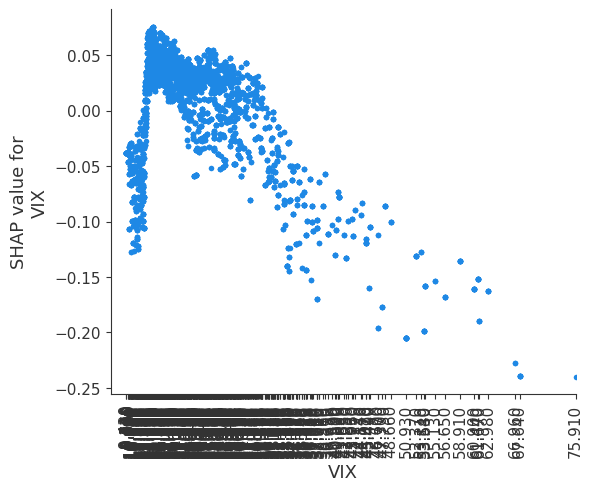

In [ ]:
feature = 'VIX'
shap.dependence_plot(
 feature,
 shap_values_random,
 random_features,
 interaction_index=None,
 xmax='percentile(99)'
)

#add more features ie
# feature = 'BDIY'
# shap.dependence_plot(
#  feature,
#  shap_values_random,
#  random_features,
#  interaction_index=None,
#  xmax='percentile(99)'
# )